<a href="https://colab.research.google.com/github/hyunwook-lee/git-money/blob/master/again_upbit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pyupbit

In [2]:
import concurrent.futures  # 병렬 처리 라이브러리
import time
import pyupbit
import numpy as np
from datetime import datetime

In [3]:
k_cache = {}

# ✅ 특정 기간 동안 최적의 k 값 찾기 (기존 코드 최적화)
def get_best_k_for_days(ticker, days):
    df = pyupbit.get_ohlcv(ticker, count=days)
    if df is None or len(df) < days:
        return 0  # 데이터 부족 시 0 반환

    best_k = 0.1
    best_ror = 0
    for k in np.arange(0.05, 1.0, 0.05):  # 0.05 단위로 탐색
        df['range'] = (df['high'] - df['low']) * k
        df['target'] = df['open'] + df['range'].shift(1)
        df['ror'] = np.where(df['high'] > df['target'],
                             df['close'] / df['target'],
                             1)
        ror = df['ror'].cumprod().iloc[-2]  # 마지막 날 수익률
        if ror > best_ror:
            best_ror = ror
            best_k = k
    return best_k

# ✅ 최적 K 값을 병렬 처리 (멀티스레딩 사용)
def get_optimal_k_parallel(ticker_list):
    global k_cache  # 캐시 사용

    def calculate_k(ticker):
        k_7 = get_best_k_for_days(ticker, 7)
        k_14 = get_best_k_for_days(ticker, 14)
        k_30 = get_best_k_for_days(ticker, 30)
        optimal_k = round((k_7 * 0.5 + k_14 * 0.3 + k_30 * 0.2), 2)
        return ticker, optimal_k

    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = executor.map(calculate_k, ticker_list)

    # 결과를 캐시에 저장
    for ticker, optimal_k in results:
        k_cache[ticker] = optimal_k

# ✅ K 값 미리 계산 후 사용
def get_k_value(ticker):
    return k_cache.get(ticker, 0.5)  # 캐시에 없으면 기본값 0.5 사용

In [4]:
ticker_list = [
    "KRW-BTC","KRW-ETH", "KRW-XRP", "KRW-SOL", "KRW-DOGE", "KRW-ADA", "KRW-TRX", "KRW-LINK", "KRW-HBAR", "KRW-XLM",
    "KRW-AVAX", "KRW-SHIB", "KRW-SUI", "KRW-DOT", "KRW-BCH", "KRW-UNI", "KRW-NEAR", "KRW-APT", "KRW-ONDO", "KRW-AAVE",
    "KRW-ETC", "KRW-TRUMP", "KRW-MNT", "KRW-VET", "KRW-POL", "KRW-ALGO", "KRW-CRO", "KRW-RENDER", "KRW-ATOM", "KRW-ARB"
]


In [5]:
get_optimal_k_parallel(ticker_list)

In [ ]:
for i in ticker_list:
  k = get_k_value(i)
  print(i,k)

KRW-BTC 0.49
KRW-ETH 0.64
KRW-XRP 0.65
KRW-SOL 0.49
KRW-DOGE 0.53
KRW-ADA 0.43
KRW-TRX 0.7
KRW-LINK 0.51
KRW-HBAR 0.82
KRW-XLM 0.6
KRW-AVAX 0.19
KRW-SHIB 0.03
KRW-SUI 0.55
KRW-DOT 0.73
KRW-BCH 0.6
KRW-UNI 0.6
KRW-NEAR 0.5
KRW-APT 0.38
KRW-ONDO 0.58
KRW-AAVE 0.2
KRW-ETC 0.25
KRW-TRUMP 0.6
KRW-MNT 0.03
KRW-VET 0.12
KRW-POL 0.5
KRW-ALGO 0.5
KRW-CRO 0.15
KRW-RENDER 0.52
KRW-ATOM 0.43
KRW-ARB 0.42


In [ ]:
df= get_ohlcv_cached("KRW-BTC", 30)
best_k = 0.1
best_ror = 0
for k in np.arange(0.05, 1.0, 0.05):  # 0.05 단위로 탐색
  df['range'] = (df['high'] - df['low']) * k
  df['target'] = df['open'] + df['range'].shift(1)
  df['ror'] = np.where(df['high'] > df['target'],
  df['close'] / df['target'],1)
  ror = df['ror'].cumprod().iloc[-2]  # 마지막 날 수익률
  print(k,ror)
  if ror > best_ror:
    best_ror = ror
    best_k = k

0.05 0.8991267837106743
0.1 0.9422068352360229
0.15000000000000002 0.9961818756998531
0.2 0.9689197422644827
0.25 0.966709174050401
0.3 1.0469925753485931
0.35000000000000003 1.0192804916208529
0.4 0.9923834154777179
0.45 1.0660867607536904
0.5 1.0457155477187903
0.55 1.076311188293079
0.6000000000000001 1.0763804444371892
0.6500000000000001 1.0796207339585098
0.7000000000000001 1.0751752061101965
0.7500000000000001 1.0691848734153828
0.8 1.0727965887326998
0.8500000000000001 1.0705246622588596
0.9000000000000001 1.0682623382425922
0.9500000000000001 1.0660095559340825


In [7]:
def get_current_price(ticker):
    """현재가 조회"""
    return pyupbit.get_orderbook(ticker=ticker)["orderbook_units"][0]["ask_price"]

# 목표 가격 및 리스크 가격 계산
def get_target_price(ticker, k):
    df = pyupbit.get_ohlcv(ticker, interval="day", count=2)
    return df.iloc[-2]['close'] + (df.iloc[-2]['high'] - df.iloc[-2]['low']) * k if df is not None else None

def get_risk_price(ticker, buy_price):
    return buy_price * 0.975 if buy_price else None  # 손절가 = 매수가 * 0.975 (-3.5%)

def get_profit_price(ticker, buy_price):
    return buy_price * 1.10 if buy_price else None  # 익절가 = 매수가 * 1.10 (+10%)

# 15일 이동 평균 + RSI 지표 추가
def get_ma15(ticker):
    df = pyupbit.get_ohlcv(ticker, interval="day", count=15)
    return df['close'].rolling(15).mean().iloc[-1] if df is not None else None

def get_rsi(ticker, period=14):
    df = pyupbit.get_ohlcv(ticker, interval="day", count=period+1)
    if df is not None:
        delta = df['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(period).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs)).iloc[-1]
    return None

In [8]:
bou=[]
for i in ticker_list:
  k = get_k_value(i)
  target_price = get_target_price(i, k)
  ma15 = get_ma15(i)
  rsi = get_rsi(i)
  current_price = get_current_price(i)
  df = pyupbit.get_ohlcv(i, interval="day", count=2)
  open_price= df.iloc[-1]['open']
  per=target_price/open_price*100
  print(i, target_price, current_price, per,ma15,rsi)
  if target_price < current_price and ma15 < current_price and 30 < rsi < 70:
    bou.append(i)

KRW-BTC 124137000.0 122092000 101.98570489648372 125670866.66666667 39.67751075393452
KRW-ETH 2833320.0 2795000 101.88133764832794 3006266.6666666665 30.582102519548215
KRW-XRP 3430.0 3416 101.50932228469962 3452.2 44.78285391990976
KRW-SOL 195820.0 187100 105.19473542841796 197826.66666666666 34.909290819131385
KRW-DOGE 251.43400000000003 249.9 101.46650524616628 268.18666666666667 32.719836400818
KRW-ADA 1053.75 1046 101.51734104046244 1165.4666666666667 35.58139534883722
KRW-TRX 324.8 315 104.10256410256412 341.93333333333334 29.545454545454547
KRW-LINK 20321.0 19880 103.15228426395939 21284.0 43.29824561403509
KRW-HBAR 287.50600000000003 275.6 105.50678899082571 311.64666666666665 31.791221826809007
KRW-XLM 395.97400000000005 389.8 102.42472840144853 407.74 33.854818523153924
KRW-AVAX 27910.0 27170 103.52373887240356 28560.666666666668 39.21760391198045
KRW-SHIB 0.0194374 0.01936 100.60766045548655 0.018831333333333332 48.79614767255216
KRW-SUI 3418.5 3332 103.87420237010028 3549.2

In [9]:
bou

['KRW-CRO']

In [10]:
df = pyupbit.get_ohlcv("KRW-BTC", interval="minute60")
df


,open,high,low,close,volume,value
2025-03-09 02:00:00,128702000.0,128805000.0,128113000.0,128313000.0,21.174747,2.717997e+09
2025-03-09 03:00:00,128350000.0,128610000.0,128226000.0,128499000.0,12.711745,1.633074e+09
2025-03-09 04:00:00,128499000.0,129016000.0,128211000.0,128680000.0,16.233734,2.088558e+09
2025-03-09 05:00:00,128678000.0,128841000.0,128530000.0,128802000.0,9.961782,1.282008e+09
2025-03-09 06:00:00,128805000.0,129065000.0,128650000.0,128663000.0,17.294897,2.228953e+09
...,...,...,...,...,...,...
2025-03-17 05:00:00,122564000.0,122963000.0,122221000.0,122656000.0,20.421584,2.502443e+09
2025-03-17 06:00:00,122663000.0,122804000.0,121912000.0,121998000.0,46.881614,5.734705e+09
2025-03-17 07:00:00,121999000.0,122228000.0,121020000.0,121050000.0,101.787516,1.237106e+10
2025-03-17 08:00:00,121050000.0,121863000.0,121023000.0,121749000.0,80.962242,9.834387e+09


In [29]:
df = df.reset_index()
df['ds'] = df['index']
df['y'] = df['close']
data = df[['ds','y']]
data


,ds,y
0,2025-03-09 02:00:00,128313000.0
1,2025-03-09 03:00:00,128499000.0
2,2025-03-09 04:00:00,128680000.0
3,2025-03-09 05:00:00,128802000.0
4,2025-03-09 06:00:00,128663000.0
...,...,...
195,2025-03-17 05:00:00,122656000.0
196,2025-03-17 06:00:00,121998000.0
197,2025-03-17 07:00:00,121050000.0
198,2025-03-17 08:00:00,121749000.0


In [26]:
import pandas as pd
from prophet import Prophet

In [30]:
model = Prophet()
model.fit(data)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqxpnav9t/eodbo1p4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqxpnav9t/e57nhqnj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99018', 'data', 'file=/tmp/tmpqxpnav9t/eodbo1p4.json', 'init=/tmp/tmpqxpnav9t/e57nhqnj.json', 'output', 'file=/tmp/tmpqxpnav9t/prophet_modelsfmk9fuv/prophet_model-20250317005005.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:50:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:50:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [31]:
future = model.make_future_dataframe(periods=24, freq='H')
forecast = model.predict(future)


/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


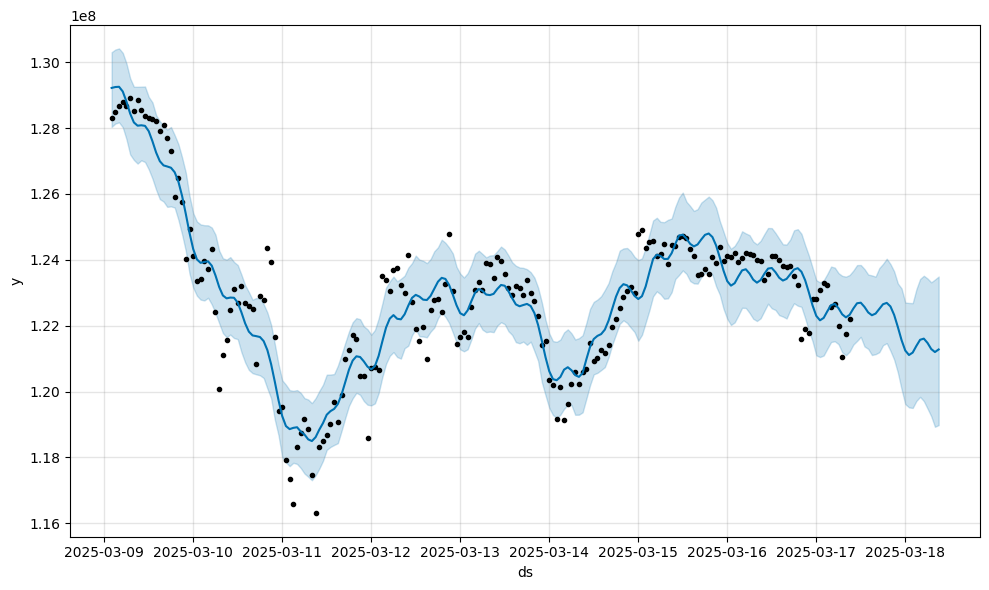

In [32]:
fig1 = model.plot(forecast)

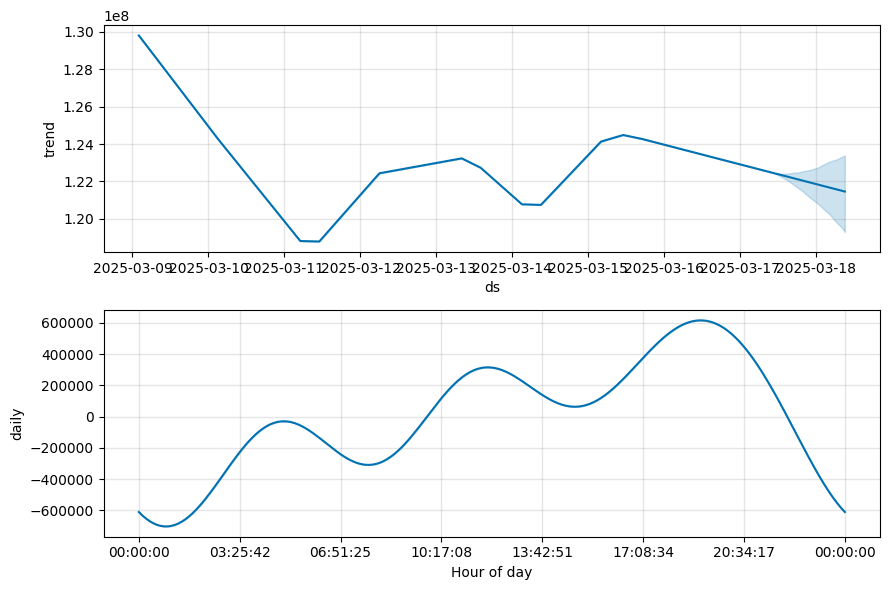

In [33]:
fig2 = model.plot_components(forecast)